In [1]:
from editor import Editor

editor = Editor()
editor.load('creatures/angles.json')
editor.run()

Welcome to the experimental pyglet+pybox2d creature editor!
- B to add a dynamic body
- Drag to move bodies
- P to pin bodies together at the current mouse position
- Arrow keys to change the size of the selected body (width, height)
- S to save models as model.json (or whatever filename you passed in load) in the current directory
File saved as: creatures/angles.json


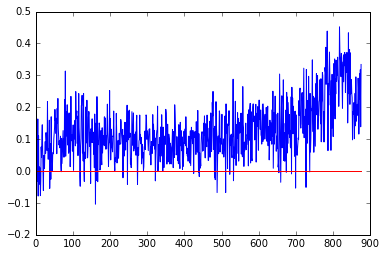

In [44]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output
from engine import Engine
from pyglet.window import key

# train your model to (hopefully) walk by running this cell

# hit s to speed up training, and s again to watch the best set of weights
# use the up and down arrow keys to introduce more or less randomness in weight changes

# This is an experiment with q learning

FILE = 'creatures/two_legs.json'

JOINT_SPEED = 3 # motor speed to use when executing a list of joint torques

# Physics engine and window
LOWER_LIM = -.1 * np.pi
UPPER_LIM = .1 * np.pi
LIMIT = True
ANGLE_RANGE = UPPER_LIM - LOWER_LIM if LIMIT else np.pi*2.0

engine = Engine(caption='Train', width=1280, height=720, ppm=15, gravity=(0, -50), joint_limit=LIMIT, \
               upper_angle=UPPER_LIM, lower_angle=LOWER_LIM, \
                linear_damping=0.0, angular_damping=0.0)

# Load creature
engine.load(FILE)

# count joints and body parts
body_count = len(engine.bodies)
joint_count = len(engine.joints)

ACTIONS = range(2**joint_count)

if body_count == 0 or joint_count == 0:
    engine.close()
    raise RuntimeError("Your model doesn't have any physics bodies or joints")

def features(time_step=0):
    f = []
        
    for j in engine.joints:
        a = j.angle
        r = (j.upperLimit - j.lowerLimit) if j.limitEnabled else np.pi*2.0
        a %= r
        a = a * 2.0 - 1.0
        f += [a]
        #f += [np.tanh(j.speed)]
        
    for b in engine.bodies:
        a = b.angle % ANGLE_RANGE
        a /= ANGLE_RANGE
        a = a * 2.0 - 1.0
        f += [a]
        f += [np.tanh(b.angularVelocity)]
        f += [np.tanh(b.linearVelocity[0])]
        f += [np.tanh(b.linearVelocity[1])]
        #f += [np.sin(a)]
        #f += [np.cos(a)]
        #f += [engine.to_window(b.position)[1]/engine.height]
        #f += [engine.to_window(b.position)[0]/engine.width]
        
    # collision
    for b in engine.bodies:
        if len(b.contacts) > 0:
            f += [1.0]
        else:
            f += [-1.0]
    
    #f += [np.sin(time_step / 2.0)] # Creature's heartbeat? :-)
    #f += [np.cos(time_step / 2.0)]
    #f += [np.sin(time_step)]
    
    f += [1] # bias
    return np.array([f])

def bit_on(a, bit):
    mask = 2**bit
    return a&mask > 0

def act(action):
    for i, j in enumerate(engine.joints):
        j.motorSpeed = JOINT_SPEED if bit_on(action, i) else -JOINT_SPEED
        
        
TIMESTEPS = 128 # timesteps per episode
PHYS_STEPS = 20
TRAIN_ITERS = 2000 # times to sample memory to update qs
MAX_MEM = 50000
BATCH_SIZE = 4
HDIM = 32

learning_rate = .0001
eps = .3 # 1: full exploration, 0: full exploitation
gamma = 0.95 # discount value of future actions

total_r = 0.0
avg_r = 0.0
episode = 0
rs = []
M = [] # (S, A, R, S, A) tuples


# model
W1 = np.random.randn(features(0).shape[1], HDIM) * .1
W2 = np.random.randn(HDIM + 1, len(ACTIONS)) * .1

def train():
    global W1, W2
    
    for i in range(TRAIN_ITERS):
        g1 = np.zeros_like(W1)
        g2 = np.zeros_like(W2)
        
        for b in range(BATCH_SIZE):
            xp = M[np.random.randint(0, len(M))]
            s0, a0, r, s1, a1 = xp

            z1, h1, qs0 = calc_qs(s0)
            _, _, qs1 = calc_qs(s1)

            targ = qs0.copy()
            targ[0, a0] = r + gamma * np.max(qs1)

            dz2 = qs0 - targ

            g2 += np.multiply(h1.T, dz2)

            dh1 = W2.dot(dz2.T).T
            dh1 = dh1[:, :-1]

            dz1 = np.multiply(dh1, actfn_p(z1))
            g1 += np.multiply(s0.T, dz1)
            
        W1 -= g1 * learning_rate
        W2 -= g2 * learning_rate

        #delta = (_r + gamma * np.max(_s1.qs) - _s0.qs[0, _a0])
        #_s0.qs[0, _a0] += learning_rate * delta
        #avg_delta += delta

#s0 = features(t)
#   qs = calc_qs(s0)
#   a0 = sample_action(qs, eps)

def calc_qs(x):
    z1 = x.dot(W1)
    h1 = actfn(z1)
    h1 = add_b(h1)
    
    z2 = h1.dot(W2)
    #h2 = actfn(z2)
    
    return z1, h1, z2

def sample_action(qs, eps):
    if all(qs[0] == qs[0, 0]):
        # all equal, random action
        return np.random.choice(ACTIONS)
    dist = [eps/len(ACTIONS) for a in ACTIONS]
    dist[np.argmax(qs[0])] += 1.0 - eps
    return np.random.choice(ACTIONS, p=dist)

actfn = lambda x: np.tanh(x)
actfn_p = lambda x: 1 - np.tanh(x)**2

add_b = lambda x: np.concatenate((x, np.ones([1, 1])), axis=1)
rm_b = lambda x: x[:, :-1]

speedup = False
running = True
interacted = False

while running:
    if not interacted:
        rs += [total_r/TIMESTEPS]
        
    if len(rs) >= 100:
        avg_r = np.sum(rs[-100:])/100.0
        
    
    if episode % 25 == 0:
        clear_output(wait=True)
        
        if len(rs) > 1000:
            rs = rs[-1000:]
        
        fig = plt.plot(rs, 'b')
        plt.plot([0, len(rs)], [0, 0], 'r')
        plt.show()
        
        # train on experience
        if len(M) > MAX_MEM:
            M = M[-MAX_MEM:]
        if len(M) > TRAIN_ITERS:
            train()
    
    # new episode
    engine.clear_all_but_ground()
    engine.load(FILE)
    engine.set_position((engine.width/2, engine.height/2))
    
    for j in engine.joints:
        j.motorSpeed = np.random.randn()
    
    engine.step_physics(50)
    for b in engine.bodies:
        b.linearVelocity = (0, 0)
        b.angularVelocity = 0
    
    episode += 1
    
    t = 0
    total_r = 0.0
    
    s0 = features(t)
    _, h0, qs0 = calc_qs(s0)
    a0 = sample_action(qs0, eps)
    
    interacted = False
    reset = False
    
    while not reset:
        
        engine.window.dispatch_events()
        
        if engine.exited():
            running = False
            reset = True
        
        engine.window.clear()
        
        # keyboard input
        if engine.window.pressed(key.UP):
            eps += 0.05
        if engine.window.pressed(key.DOWN):
            eps -= 0.05
        if engine.window.pressed(key.S):
            speedup = not speedup
            
        if eps < 0.0:
            eps = 0.0
        if eps > 1.0:
            eps = 1.0
            
        engine.window.reset_keys()
        
        if engine.window.mouse_pressed:
            engine.create_mouse_joint()
            interacted = True
        else:
            engine.destroy_mouse_joint()
        
        engine.update_mouse_joint()
        
        state_value = np.round(np.mean(qs0), 2)
        text = 'episode: {} avg reward: {} eps: {} memories: {} state value: {}'.format(\
                episode, np.round(avg_r, 2), np.round(eps, 2), len(M), state_value)
        
        
        start_p = engine.body_position()
        
        act(a0)
        
        act_m = np.zeros([1, len(ACTIONS)])
        act_m[:] = -1
        act_m[0, a0] = 1
        matrices = [s0.T, W1, h0.T, W2, qs0.T, act_m.T]
        if not speedup:
            engine.window.draw_matrices(matrices, recalc=True)
        
        for i in range(PHYS_STEPS):
            engine.step_physics(1)
            if not speedup:
                engine.window.clear()
                engine.window.draw_matrices(matrices, recalc=False)
                engine.window.draw_text(text)
                engine.render()
                engine.clock_tick()
                
        end_p = engine.body_position()
        
        # reward
        reward = end_p[0] - start_p[0]
        reward /= PHYS_STEPS
        
        total_r += reward
        
        s1 = features(t)
        _, h1, qs1 = calc_qs(s1)
        a1 = sample_action(qs1, eps)
        
        
        if not interacted:
            # remember
            M += [(s0, a0, reward, s1, a1)]
                
        if end_p[0] > engine.width/2 + 400:
            engine.set_position((engine.width/2 - 350, end_p[1]), zero_vel=False)
        elif end_p[0] < engine.width/2 - 400:
            engine.set_position((engine.width/2 + 350, end_p[1]), zero_vel=False)
            
            
        if t > TIMESTEPS and speedup:
            reset = True
            if episode % 10 == 0:
                engine.window.clear()
                engine.window.draw_matrices(matrices)
                engine.window.draw_text(text)
                engine.render()
        
        t += 1
        
        s0 = s1.copy()
        h0 = h1.copy()
        a0 = a1

engine.close()

In [3]:
engine.joints

[b2RevoluteJoint(active=True,
                 anchorA=b2Vec2(18.228,8.80671),
                 anchorB=b2Vec2(18.228,8.80671),
                 angle=-0.3433189392089844,
                 bodyA=b2Body(active=True,
                              angle=0.00851431954652071,
                              angularDamping=0.0,
                              angularVelocity=0.0,
                              awake=False,
                              bullet=False,
                              contacts=[],
                              fixedRotation=False,...  ),
                 bodyB=b2Body(active=True,
                              angle=1.1805181503295898,
                              angularDamping=0.0,
                              angularVelocity=0.0,
                              awake=False,
                              bullet=False,
                              contacts=[b2ContactEdge(contact=b2Contact(childIndexA=0,...  ),
                 limitEnabled=True,
                 limit